In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

In [2]:
gpa = pd.read_csv("/home/mliva/salmonella-pangenome-SP/03-results/03.1-panaroo/gene_presence_absence.csv")

In [3]:
genome_columns = gpa.columns[3:]
print(genome_columns)

Index(['Alberta_EC20090641_SRR1183981', 'Alberta_EC20090698_SRR1183982',
       'Alberta_EC20111514_GCF_000624295', 'Alberta_EC20111515_GCF_000624315',
       'Alberta_EC20120677_GCF_000625755',
       'British_Columbia_EC20111510_GCF_000626555',
       'British_Columbia_EC20111554_GCF_000624335',
       'British_Columbia_EC20120685_GCF_000625535',
       'British_Columbia_EC20120686_GCF_000625555',
       'British_Columbia_EC20120765_GCF_000624995',
       'New_Brunswick_N13-02934_SRR5241846',
       'New_Brunswick_N13-02944_SRR5241820',
       'New_Brunswick_N13-02946_SRR5241852',
       'Nova_Scotia_EC20120590_GCF_000625495', 'Ontario_EC20090135_SRR1183989',
       'Ontario_EC20090193_SRR1183988', 'Ontario_EC20090332_SRR1183990',
       'Ontario_EC20100130_SRR1183993', 'Ontario_EC20120916_GCF_000624155',
       'Quebec_N13-01311_SRR5239213', 'Quebec_N13-01312_SRR5239201',
       'Quebec_N13-01323_SRR5241839', 'Quebec_N13-01330_SRR5241836',
       'Quebec_N13-01348_SRR5241832'],
    

## pan vs core

In [4]:
# This function estimates pangenome and core genome accumulation curves
# by repeatedly sampling random subsets of genomes without replacement.
# For each subset size, it computes the mean number of pan and core genes
# and derives 95% confidence intervals based on bootstrap resampling.

def pangenome_curve_ci(df, genome_columns, n_iter=100):
    
    pan_mean, pan_low, pan_high = [], [], []
    core_mean, core_low, core_high = [], [], []
    
    for i in range(1, len(genome_columns) + 1):
        
        pan_i = []
        core_i = []
        
        for _ in range(n_iter):
            
            subset = np.random.choice(genome_columns, i, replace=False)
            sub_df = df[subset]
            
            presence = sub_df.notna().sum(axis=1)
            
            pan_i.append((presence >= 1).sum())
            core_i.append((presence == i).sum())
        
        pan_mean.append(np.mean(pan_i))
        pan_low.append(np.percentile(pan_i, 2.5))
        pan_high.append(np.percentile(pan_i, 97.5))
        
        core_mean.append(np.mean(core_i))
        core_low.append(np.percentile(core_i, 2.5))
        core_high.append(np.percentile(core_i, 97.5))
    
    return {
        "pan_mean": pan_mean,
        "pan_low": pan_low,
        "pan_high": pan_high,
        "core_mean": core_mean,
        "core_low": core_low,
        "core_high": core_high
    }


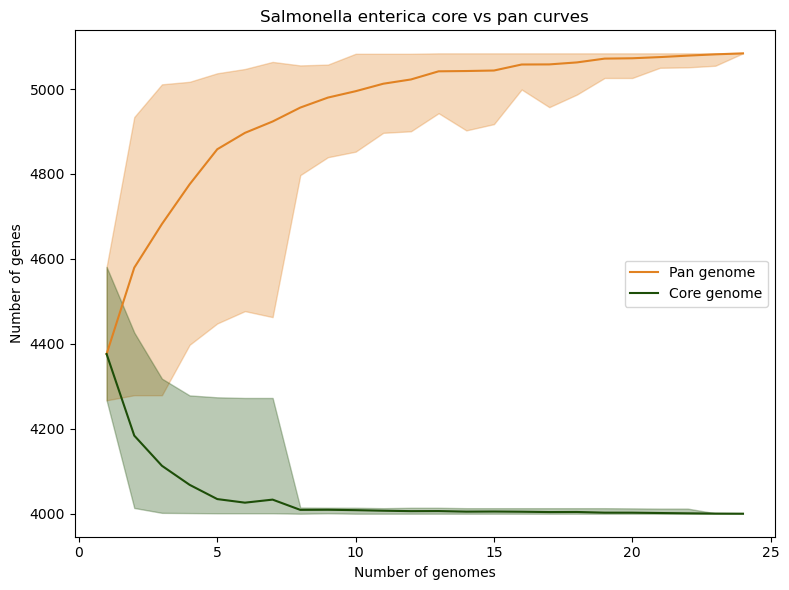

In [15]:
out_dir = "/home/mliva/salmonella-pangenome-SP/03-results/03.3-core_vs_pan_curves"

np.random.seed(10)

res = pangenome_curve_ci(gpa, genome_columns, n_iter=100)

x = range(1, len(genome_columns) + 1)

plt.figure(figsize=(8,6))

plt.plot(x, res["pan_mean"], color= "#e18222", label="Pan genome")
plt.fill_between(x, res["pan_low"], res["pan_high"], color="#e18222", alpha=0.3)

plt.plot(x, res["core_mean"], color= "#1d4e08", label="Core genome")
plt.fill_between(x, res["core_low"], res["core_high"], color = "#1d4e08", alpha=0.3)

plt.title("Salmonella enterica core vs pan curves")
plt.xlabel("Number of genomes")
plt.ylabel("Number of genes")
plt.legend()
plt.tight_layout()
plt.savefig(f"{out_dir}/pangenome_core_vs_pan_curve_intervals.png", dpi=300)
plt.show()


## Salmonella enterica core vs pan curves per serovar

In [5]:
# Metadata genoma -> ST
meta = pd.read_csv("/home/mliva/salmonella-pangenome-SP/01-data/01.2-Metadata/metadata_samples.tsv", sep="\t")
st_map = dict(zip(meta.sample_fasta, meta.sequence_type))

# Separate genomes by ST
st11_genomes = [g for g in genome_columns if st_map.get(g) == "ST11"]
st15_genomes = [g for g in genome_columns if st_map.get(g) == "ST15"]


In [6]:
# Pangenoma per serovar, choosing the columns 

genomes_St11 = gpa[st11_genomes]
genomes_St15 = gpa[st15_genomes]

print(genomes_St11.shape)
print(genomes_St15.shape)

genome_st11_columns = genomes_St11.columns
genome_st15_columns = genomes_St15.columns


(5084, 16)
(5084, 8)


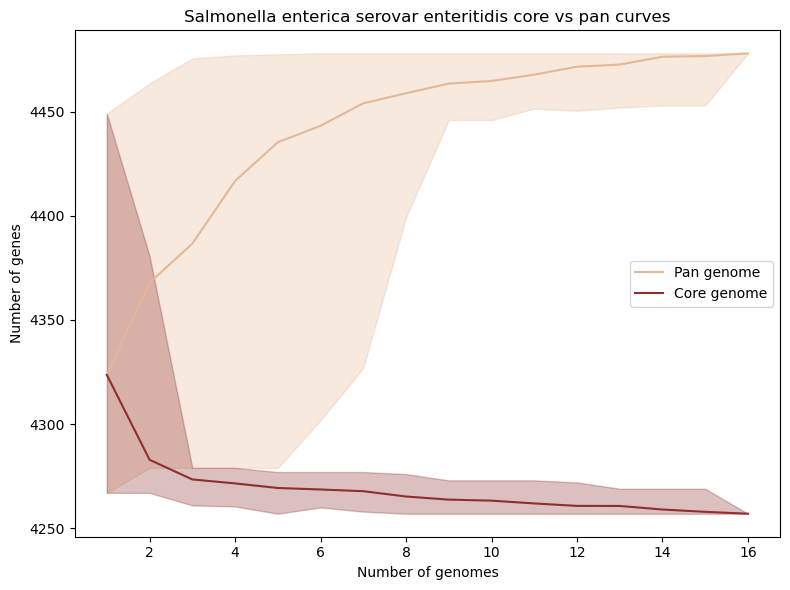

In [9]:
np.random.seed(10)

res = pangenome_curve_ci(genomes_St11, genome_st11_columns, n_iter=100)

x = range(1, len(genome_st11_columns) + 1)

plt.figure(figsize=(8,6))

plt.plot(x, res["pan_mean"], color= "#E6B794", label="Pan genome")
plt.fill_between(x, res["pan_low"], res["pan_high"], color= "#E6B794", alpha=0.3)

plt.plot(x, res["core_mean"], color= "#8E2F2E", label="Core genome")
plt.fill_between(x, res["core_low"], res["core_high"], color= "#8E2F2E", alpha=0.3)

plt.title("Salmonella enterica serovar enteritidis core vs pan curves")
plt.xlabel("Number of genomes")
plt.ylabel("Number of genes")
plt.legend()
plt.tight_layout()
plt.savefig(f"{out_dir}/pangenome_salmonella_enteritidis_core_vs_pan_curve_intervals.png", dpi=300)
plt.show()

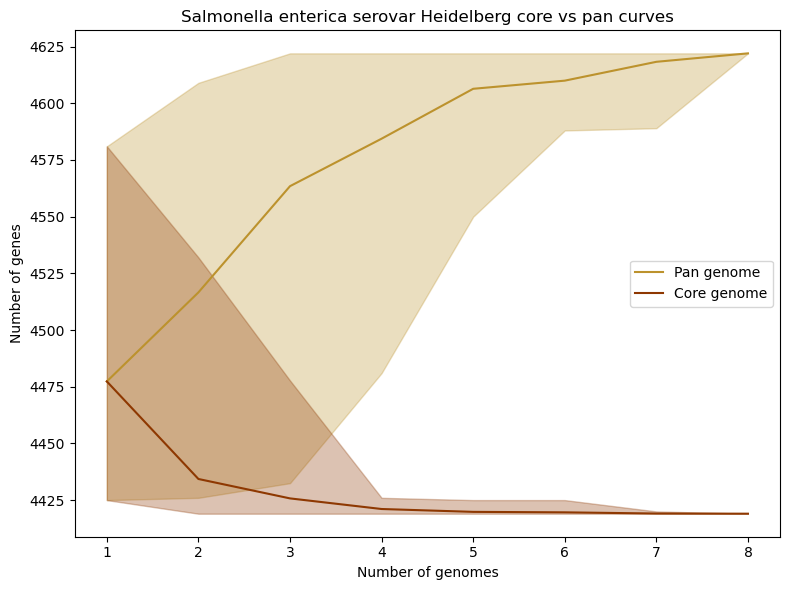

In [11]:
np.random.seed(10)

res = pangenome_curve_ci(genomes_St15, genome_st15_columns, n_iter=100)

x = range(1, len(genome_st15_columns) + 1)

plt.figure(figsize=(8,6), facecolor="none")

plt.plot(x, res["pan_mean"], color="#BC922D", label="Pan genome")
plt.fill_between(x, res["pan_low"], res["pan_high"], color="#BC922D", alpha=0.3)

plt.plot(x, res["core_mean"], color="#8E3801", label="Core genome")
plt.fill_between(x, res["core_low"], res["core_high"], color="#8E3801", alpha=0.3)

plt.title("Salmonella enterica serovar Heidelberg core vs pan curves")
plt.xlabel("Number of genomes")
plt.ylabel("Number of genes")
plt.legend()
plt.tight_layout()
plt.savefig(f"{out_dir}/pangenome_salmonella_heidelberg_core_vs_pan_curve_intervals_transparent.png", transparent=True, dpi=300)
plt.show()